In [24]:
import pandas as pd

df = pd.read_csv('merged_data.csv')
df.head()


,시점,지역,기업수,합계출산율
0,2021,강원,419563.0,0.979
1,2021,울산,231598.0,0.940
2,2021,경기,3913516.0,0.853
3,2021,경북,728744.0,0.966
4,2021,광주,380215.0,0.896


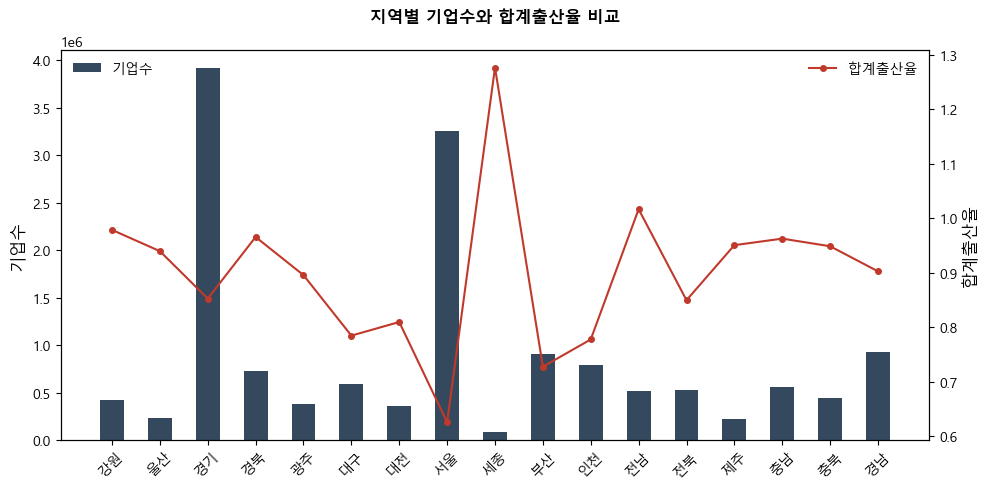

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 데이터 읽기
df = pd.read_csv('merged_data.csv')

# 2023년 데이터 필터링
data_2023 = df[df['시점'] == 2021].copy()

# 합계출산율을 숫자형으로 변환
data_2023['합계출산율'] = pd.to_numeric(data_2023['합계출산율'], errors='coerce')

# 그래프 설정
fig, ax1 = plt.subplots(figsize=(10, 5))

# 막대 그래프 (기업수)
ax1.bar(data_2023['지역'], data_2023['기업수'], width=0.5, color=(52/255, 73/255, 94/255, 1.0), label='기업수')
ax1.set_title('지역별 기업수와 합계출산율 비교', pad=20, fontweight='bold')
ax1.set_ylabel('기업수', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xticks(range(len(data_2023['지역'])))
ax1.set_xticklabels(data_2023['지역'], rotation=45, fontsize=10)

# 두 번째 y축 (합계출산율)
ax2 = ax1.twinx()
ax2.plot(data_2023['지역'], data_2023['합계출산율'], color=(192/255, 57/255, 43/255, 1.0), marker='o', markersize=4, label='합계출산율')
ax2.set_ylabel('합계출산율', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)

# 범례 설정
ax1.legend(loc='upper left', frameon=False)
ax2.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


In [26]:
df.rename(columns={'지역': '지역별'}, inplace=True)

In [29]:
# '시점'을 datetime 형식으로 변환
df['시점'] = pd.to_datetime(df['시점'].astype(str) + '-01-01')

# 인덱스로 설정
yearly_data = df.set_index('시점')

# 지역별로 그룹화 후 리샘플링
monthly_dfs = []

for region, group in yearly_data.groupby('지역별'):
    monthly_df = group.resample('ME').agg({'기업수': 'mean'}).round(3)

    # 보간
    monthly_df = monthly_df.interpolate(method='linear')
    
    # NaN 값 처리
    monthly_df.fillna(0, inplace=True)
    
    # 시점 다시 설정
    monthly_df.reset_index(inplace=True)
    
    # '시점'이 datetime 형식으로 되어 있어야 함
    # 마지막 년도에 12월 데이터 추가
    last_year = monthly_df['시점'].dt.year.max()
    last_month = monthly_df['시점'].dt.month.max()
    
    # 12월 데이터가 없으면 추가
    if last_month < 12:
        new_row = pd.DataFrame({
            '기업수': [monthly_df['기업수'].iloc[-1]],  # 마지막 값을 사용
            '시점': [pd.Timestamp(year=last_year, month=12, day=1)],
            '지역별': [region]
        })
        monthly_df = pd.concat([monthly_df, new_row], ignore_index=True)

    # 지역별 컬럼 추가
    monthly_df['지역별'] = region
    
    monthly_dfs.append(monthly_df)

# 모든 지역별 데이터를 하나의 DataFrame으로 결합
final_monthly_df = pd.concat(monthly_dfs, ignore_index=True)

# '시점'을 문자열로 다시 포맷
final_monthly_df['시점'] = final_monthly_df['시점'].dt.strftime('%Y.%m')

# 기업수 형식 변경
final_monthly_df['기업수'] = final_monthly_df['기업수'].map(lambda x: f"{x:.0f}")

# 데이터 저장
final_monthly_df.to_csv('기업수(월별).csv', index=False)

# 결과 확인
print(final_monthly_df.tail(12), final_monthly_df.shape, final_monthly_df['지역별'].unique())


           시점     기업수 지역별
1229  2020.02  388504  충북
1230  2020.03  393663  충북
1231  2020.04  398822  충북
1232  2020.05  403981  충북
1233  2020.06  409140  충북
1234  2020.07  414299  충북
1235  2020.08  419458  충북
1236  2020.09  424617  충북
1237  2020.10  429776  충북
1238  2020.11  434935  충북
1239  2020.12  440094  충북
1240  2021.01  445253  충북 (1241, 3) ['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']


C:\Users\user\AppData\Local\Temp\ipykernel_3120\3348773618.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['시점'] = pd.to_datetime(df['시점'].astype(str) + '-01-01')
